In [201]:
import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from chembl_webresource_client.new_client import new_client
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Reshape, GRU, SpatialDropout1D, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("../data/drug_class_identification/phase1/drugbank.csv")
df.head(100)
df.drop(df[df.smiles.isna()].index, inplace = True)
df.drop(df[df.atc.isna()].index, inplace = True)
df.drop(df[[False if len(smile)<250 else True for smile in df.smiles]].index, inplace = True)

In [3]:
df['atc1'] = [a[0] for a in df['atc']]

In [4]:
df.head()

,name,atc,inchi_key,smiles,atc1
13,goserelin,L02AE03,BLCLNMBMMGCOAS-URPVMXJPSA-N,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,L
33,desmopressin,H01BA02,NFLWUMRGJYTJIN-NXBWRCJVSA-N,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,H
47,cetrorelix,H01CC02,SBNPWPIBESPSIF-MHWMIDJBSA-N,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,H
84,ciclosporin,L04AD01,PMATZTZNYRCHOR-CGLBZJNRSA-N,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\C=C\C)N...,L
95,octreotide,H01CB02,DEQANNDTNATYII-OULOTJBUSA-N,[H][C@]1(NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC2=CN...,H


In [5]:
df.describe()

,name,atc,inchi_key,smiles,atc1
count,2737,2737,2737,2737,2737
unique,2737,2640,2737,2737,14
top,amisulpride,J01CR50,GSDSWSVVBLHKDQ-UHFFFAOYSA-N,FC(F)OC(F)(F)C(F)Cl,N
freq,1,22,1,1,469


In [6]:
df['smiles'] = [smile.ljust(250, '*') for smile in df['smiles']] 

### One Hot Encoding

In [7]:
vocabulary = set()
allSmiles = ""
for smile in df['smiles']:
    allSmiles+=smile
    for char in smile:
        vocabulary.add(char)
freq = Counter(allSmiles).most_common(25)

In [8]:
vocabulary = [a for a,b in freq]

In [9]:
'*' in vocabulary

True

In [10]:
oe = OneHotEncoder(handle_unknown='ignore')
oe.fit(np.asarray(vocabulary).reshape(-1, 1))

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [11]:
def encodeSmile(smile, oe):
    word = []
    for char in smile:
        temp = list(oe.transform(np.asarray([char]).reshape(1, -1)).toarray()[0])
        word = word + temp
    return np.asarray(word, dtype=int)

In [12]:
X = []
X = [encodeSmile(smile, oe) for smile in df['smiles']]

In [13]:
X = np.asarray(X)

### Prepare Data

In [14]:
oeAtc = OneHotEncoder()
y = oeAtc.fit_transform(np.asarray(df['atc1']).reshape(-1, 1)).toarray()

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [90]:
temp = [[0 for b in range(0, 14)] for a in range(0, 14)]
for a in range(0, 14):
    temp[a][a] = 1
temp = np.asarray(temp)
atc_classes = oeAtc.inverse_transform(temp).reshape(14)

### Helper function

In [107]:
def accuracy(y_true, y_pred, atc_classes=atc_classes):
    print("Overall Accuracy:", np.sum(np.equal(y_true, y_pred))/y_true.shape[0])
    matrix = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix,annot=True,cbar=False, xticklabels=atc_classes, yticklabels=atc_classes)

### Make the network

In [202]:
class Network:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Reshape((250, 25), input_shape=(6250, )))
        self.model.add(Conv1D(192, 5, activation='relu', input_shape=(250, 25)))
        self.model.add(SpatialDropout1D(0.2))
        
#         self.model.add(LSTM(150, dropout=0.7, recurrent_dropout=0.2, activation='selu', return_sequences=True,))
#         self.model.add(LSTM(100, dropout=0.7, recurrent_dropout=0.2, activation='selu'))
        self.model.add(Conv1D(128, 5, activation='relu'))
#         self.model.add(Conv1D(64, 100, activation='selu'))
        self.model.add(Flatten())
        self.model.add(Dropout(rate=0.4))
        self.model.add(Dense(14, activation='softmax'))
        self.model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
        print(self.model.summary())
        
    def train(self, X, y, epochs=20):
        self.model.fit(X, y, epochs=epochs)
    
    def test(self, X, y):
        y_pred = self.model.predict(X).argmax(axis=1)
        y_true = y.argmax(axis=1)
        accuracy(y_true, y_pred)
        

In [203]:
network = Network()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_44 (Reshape)         (None, 250, 25)           0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 246, 192)          24192     
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 246, 192)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 242, 128)          123008    
_________________________________________________________________
flatten_21 (Flatten)         (None, 30976)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30976)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 14)                433678    
Total para

In [204]:
network.train(X_train, y_train, epochs=10)

Epoch 1/10
1833/1833 [==============================] - 13s 7ms/step - loss: 3.0682 - acc: 0.2089
Epoch 2/10
1833/1833 [==============================] - 9s 5ms/step - loss: 2.2215 - acc: 0.2859
Epoch 3/10
1833/1833 [==============================] - 9s 5ms/step - loss: 1.9573 - acc: 0.3628
Epoch 4/10
1833/1833 [==============================] - 9s 5ms/step - loss: 1.7252 - acc: 0.4315
Epoch 5/10
1833/1833 [==============================] - 9s 5ms/step - loss: 1.5228 - acc: 0.5095
Epoch 6/10
1833/1833 [==============================] - 9s 5ms/step - loss: 1.3840 - acc: 0.5543
Epoch 7/10
1833/1833 [==============================] - 10s 5ms/step - loss: 1.2595 - acc: 0.5821
Epoch 8/10
1833/1833 [==============================] - 10s 6ms/step - loss: 1.1307 - acc: 0.6334
Epoch 9/10
1833/1833 [==============================] - 9s 5ms/step - loss: 1.0457 - acc: 0.6601
Epoch 10/10
1833/1833 [==============================] - 9s 5ms/step - loss: 0.9574 - acc: 0.6825


Overall Accuracy: 0.26216814159292035
              precision    recall  f1-score   support

           0       0.19      0.23      0.21       101
           1       0.12      0.03      0.05        34
           2       0.20      0.26      0.23       116
           3       0.30      0.18      0.22        62
           4       0.37      0.29      0.32        59
           5       0.00      0.00      0.00         7
           6       0.51      0.37      0.43        98
           7       0.32      0.24      0.27        71
           8       0.12      0.04      0.06        49
           9       0.26      0.52      0.35       134
          10       0.29      0.06      0.10        33
          11       0.19      0.22      0.21        63
          12       0.11      0.03      0.05        30
          13       0.29      0.28      0.28        47

   micro avg       0.26      0.26      0.26       904
   macro avg       0.23      0.20      0.20       904
weighted avg       0.27      0.26      0.2

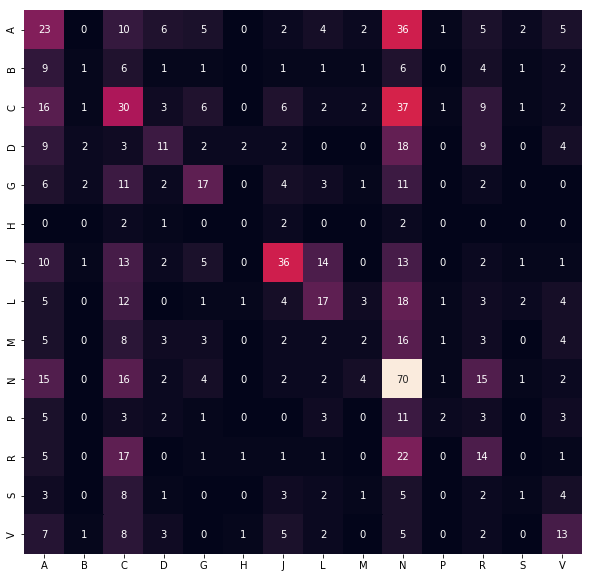

In [205]:
s = network.test(X_test, y_test)

In [183]:
Counter(df.atc1).most_common(14)

[('N', 469),
 ('C', 344),
 ('A', 316),
 ('J', 288),
 ('L', 211),
 ('R', 196),
 ('D', 173),
 ('G', 152),
 ('M', 138),
 ('V', 136),
 ('S', 98),
 ('P', 90),
 ('B', 89),
 ('H', 37)]